# Tracer Boundary Indexing

* A notebook of where to set the tracer boundary

In [1]:
import sys
sys.path.insert(0, '_libs/')
import NEMO_tools as Nts

In [2]:
import glob
import scipy.io
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [3]:
reload(Nts)

<module 'NEMO_tools' from '_libs/NEMO_tools.pyc'>

#ORCA2

In [4]:
MAT = scipy.io.loadmat('_data/Exchange/NEMO_ORCA2_Ba.mat')
Ba_ini_orca = MAT['Ba_ini_orca'][:]
nav_lat = MAT['nav_lat'][:]
nav_lon = MAT['nav_lon'][:]
#
MAT = scipy.io.loadmat('_data/Exchange/NEMO_ORCA2_d18O.mat')
d18O_ini_orca = MAT['d18O_ini_orca'][:]
nav_lat = MAT['nav_lat'][:]
nav_lon = MAT['nav_lon'][:]

In [5]:
Ba_ini_orca.shape

(31L, 149L, 182L)

In [6]:
field = np.zeros([31, 149, 182])
domain = np.zeros(nav_lon.shape)
Ba_boundary = np.zeros([31, 149, 182])
d18O_boundary = np.zeros([31, 149, 182])

In [7]:
domain[~np.isnan(Ba_ini_orca[0, :, :])]=1.0

In [12]:
for i in range(182):
    for j in range(148):
        for k in range(31):
            if (np.isnan(Ba_ini_orca[k, j, i]) and (~np.isnan(Ba_ini_orca[k, j+1, i]))):
                field[k, j+1, i] = 1.0
                field[k, j  , i] = 1.0
                field[k, j-1, i] = 1.0

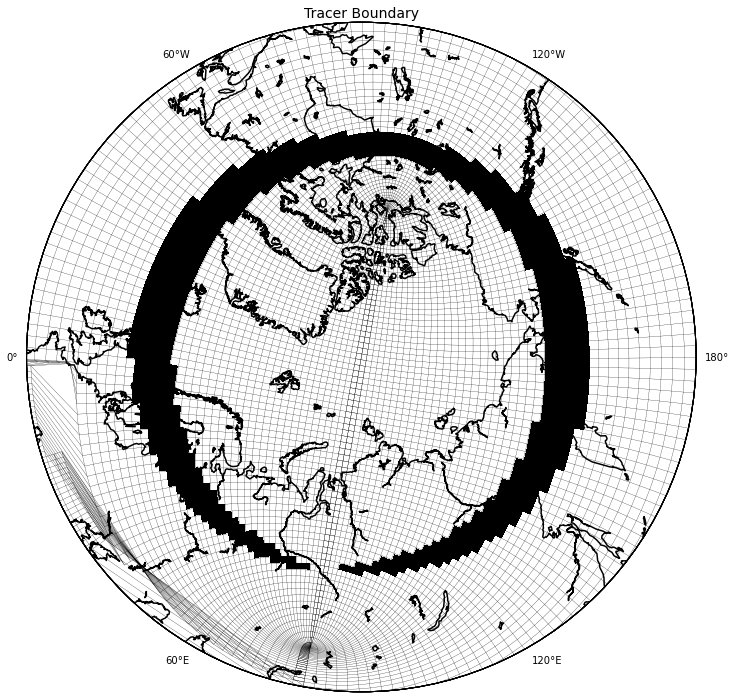

In [13]:
fig=plt.figure(figsize=(12, 12)); ax=plt.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=45, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
#proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y = proj(nav_lon, nav_lat)
proj.pcolor(x, y, field[1, :, :], cmap=plt.cm.gray_r)
proj.plot(x, y, 'k-', linewidth=0.25)#, alpha=0.25);
proj.plot(x.T, y.T, 'k-', linewidth=0.25)#, alpha=0.25)
#proj.plot(x[135, -48], y[135, -48], 'ro', ms=12)
ax.set_title('Tracer Boundary', fontsize=14)
plt.show()
#fig.savefig('Publish/Barium_boundary.pdf', dpi=600, orientation='portrait', papertype='a4', format='pdf',
#            transparent=False, bbox_inches='tight', pad_inches=0)

In [14]:
for i in range(182):
    for j in range(149):
        for k in range(31):
            if (field[k, j, i]==1):
                Ba_boundary[k, j, i] = Ba_ini_orca[k, j, i]
                d18O_boundary[k, j, i] = d18O_ini_orca[k, j, i]
            else:
                Ba_boundary[k, j, i] = -999.9
                d18O_boundary[k, j, i] = -999.9

<matplotlib.contour.QuadContourSet instance at 0x000000000F719F48>

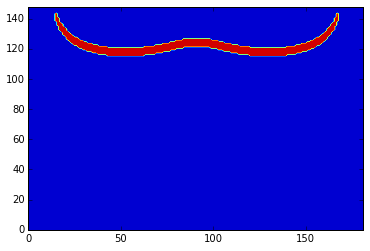

In [23]:
#plt.contourf(d18O_ini_orca[2, :, :])
plt.contourf(field[0, :, :])

In [24]:
save_var = { 'Ba': Ba_boundary, 'd18O': d18O_boundary, 'domain': domain}
scipy.io.savemat('_data/Exchange/TRC_BOUND.mat', mdict=save_var)

#ANHA4

In [ ]:
ANHA4_MAT = scipy.io.loadmat('_data/Exchange/NEMO_ANHA4_Ba.mat')
Ba_ini_ANHA4 = ANHA4_MAT['Ba_ini_orca'][:]
nav_lat = ANHA4_MAT['nav_lat'][:]
nav_lon = ANHA4_MAT['nav_lon'][:]

In [ ]:
field_ANHA4 = np.zeros(nav_lon.shape)
domain_ANHA4 = np.zeros(nav_lon.shape)
Ba_boundary_ANHA4 = np.zeros(nav_lon.shape)

In [ ]:
domain[~np.isnan(Ba_ini_ANHA4[0, :, :])]=1.0

In [ ]:
nav_lat.shape

In [ ]:
for i in range(544):
    for j in range(800):
        if (np.isnan(Ba_ini_ANHA4[0, j, i]) and (~np.isnan(Ba_ini_ANHA4[0, j+1, i]))):
            field_ANHA4[j+1, i] = 1.0

In [ ]:
fig=plt.figure(figsize=(12, 12)); ax=plt.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=45, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
#proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y = proj(nav_lon, nav_lat)
proj.pcolor(x, y, field_ANHA4, cmap=plt.cm.gray_r)
proj.plot(x, y, 'k-', linewidth=0.25)#, alpha=0.25);
proj.plot(x.T, y.T, 'k-', linewidth=0.25)#, alpha=0.25)
ax.set_title('Tracer Boundary (ANHA4)', fontsize=14)
plt.show()
#fig.savefig('Publish/Barium_boundary.pdf', dpi=600, orientation='portrait', papertype='a4', format='pdf',
#            transparent=False, bbox_inches='tight', pad_inches=0)

In [ ]:
save_var = { 'Ba_boundary': Ba_boundary_ANHA4, 'domain': domain_ANHA4}
scipy.io.savemat('_data/Exchange/Ba_boundary_ANHA4.mat', mdict=save_var)